In [2]:
from typing import Annotated 
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages 
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model
from langchain_core.tools import Tool
from langchain_core.messages import BaseMessage
import os


In [4]:
load_dotenv()

langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_API_KEY"] = langsmith_api_key
os.environ["LANGSMITH_TRACING"] = "true" 

google_api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = google_api_key


llm = init_chat_model("google_genai:gemini-2.0-flash")

E0000 00:00:1760425366.971644   14791 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [5]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

tool_node=ToolNode([add])
llm_with_tools = llm.bind_tools([add])

In [6]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

def call_llm_model(state: State) -> State:
    return {"messages": llm_with_tools.invoke(state["messages"])}

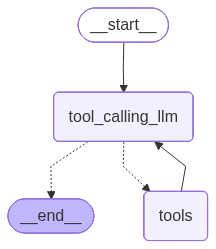

In [10]:
builder = StateGraph(State)
builder.add_node("tool_calling_llm", call_llm_model)
builder.add_node("tools", ToolNode([add]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
response = graph.invoke({"messages": "What is the recent AI news"})
response

{'messages': [HumanMessage(content='What is the recent AI news', additional_kwargs={}, response_metadata={}, id='48767694-c043-4994-b707-8e9d30a55358'),
  AIMessage(content='I am sorry, I cannot access external websites or specific news articles. Therefore, I am unable to provide you with recent AI news.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cb084d28-b694-48ac-bdcc-df5b91c603f7-0', usage_metadata={'input_tokens': 18, 'output_tokens': 28, 'total_tokens': 46, 'input_token_details': {'cache_read': 0}})]}

In [11]:
response = graph.invoke({"messages": "What is 2 + 4"})
response

{'messages': [HumanMessage(content='What is 2 + 4', additional_kwargs={}, response_metadata={}, id='61710ad2-8ec3-42be-b7f6-08e2c9ae4ef5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 2, "b": 4}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--e05c2e06-4782-4e7e-aeab-d4cadff24270-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 4}, 'id': 'dab21639-6471-4fee-b052-4f248ec9162b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 19, 'output_tokens': 5, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='6', name='add', id='12177860-2cb7-4f0d-b75c-1baf08fd76cd', tool_call_id='dab21639-6471-4fee-b052-4f248ec9162b'),
  AIMessage(content='2 + 4 = 6', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STO